In [60]:
import dask.dataframe as dd
import pandas as pd
import torch
import numpy as np
%matplotlib inline

In [61]:
data = pd.read_csv('/storage/jetblueData.csv', dtype={'Loc': 'object','ts': 'object'})

In [62]:
# from transformers import *
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = BertModel.from_pretrained('bert-base-cased')

In [63]:

stopwords = ['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 'not',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 "don't",
 'should',
 "should've",
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ain',
 'aren',
 "aren't",
 'couldn',
 "couldn't",
 'didn',
 "didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 "on",
"and","for",
 'wouldn',
 "wouldn't","jetblue", "jetblue,", "JetBlue,", "jetblu"]

In [64]:
sentences = []
for doc in data['review'].dropna():
    for sentence in doc.split("."):
        sentences.append(sentence.strip())

reviews = pd.DataFrame(sentences, columns=['review_sentence'])

In [65]:
import en_vectors_web_lg

nlp = en_vectors_web_lg.load()

## Distance Functions

$$ argmax_{y} \dfrac{X . Y}{||X|| ||Y||} $$

$X = $ Review vector

$Y = $ Aspect vector

In [66]:
def construct_sentence_vector(sentence):
    return np.array([token.vector for token in nlp(sentence)]).mean(axis=0)

In [67]:
def construct_dim_vector(descriptive_words):
    return np.array([construct_sentence_vector(sentence) for sentence in descriptive_words]).mean(axis=0)

In [69]:
def euclidian_distance(X, Y):
    return np.sqrt(np.sum(np.power(X-Y, 2)))

In [70]:
def cosine_sim(X, Y):
    return np.dot(X, Y)/(np.linalg.norm(X) * np.linalg.norm(Y))

In [72]:
classes = ['customer_experience','punctuality','cancel','comfort', 'misc']
lexicon = {
    'customer_service': ['service','smooth','customer service', 'empathatic crew', 'attendant', 'attendants', 'excellent crew', 'attentive customer service', 'staff service'],
    'punctuality_words': ['time', 'schedule', 'punctual', 'delayed'],
    'cancel': ['cancel', 'cancellation', 'credit', 'refund'],
    'comfort': ['comfort','comfortable','leg room','seats','baggage']
}

lexicon_vectors = {}
for aspect, descriptive_words in lexicon.items():
    lexicon_vectors[aspect] = construct_dim_vector(descriptive_words)

In [73]:
def select_aspect(review):
    vec = construct_sentence_vector(review)
    sims = np.array(list(map(lambda lex_v: cosine_sim(vec, lex_v), lexicon_vectors.values())))
    max_cat = np.argmax(sims) if sims.max() > 0.40 else -1
    return max_cat


predicted_aspects=dd.from_pandas(reviews['review_sentence'], npartitions=4).apply(select_aspect, meta=('review_sentence', 'object')).compute()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice.



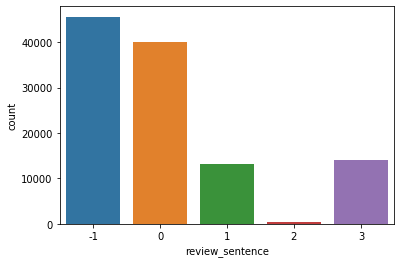

In [74]:
import seaborn as sns
sns.countplot(predicted_aspects)

In [31]:
reviews['aspect']=predicted_aspects

In [37]:
reviews.to_csv('/storage/aspect_reviews.csv', index=None)

In [41]:
sentiment_data = pd.read_csv('/storage/sentence_sentiment_analysis.csv').drop('Unnamed: 0', axis=1)

In [55]:
sentiment_aspect_dataset = sentiment_data.merge(reviews, on=sentiment_data.index).drop(['key_0', 'review_sentence_x'], axis=1)

In [77]:
sentiment_aspect_dataset['aspect'] = sentiment_aspect_dataset['aspect'].apply(lambda ix:classes[ix])

In [57]:
sentiment_aspect_dataset['review_sentence'] = sentiment_aspect_dataset['review_sentence_y']
sentiment_aspect_dataset = sentiment_aspect_dataset.drop('review_sentence_y', axis=1)

In [92]:
sentiment_aspect_dataset = sentiment_aspect_dataset[sentiment_aspect_dataset['review_sentence'].apply(lambda r:len(r.strip()) >= 5)]

In [5]:
sentiment_aspect_dataset = pd.read_csv('merged_sentiment_and_aspect.csv')

In [93]:
sentiment_aspect_dataset.to_csv('merged_sentiment_and_aspect.csv', index=None)

# Model Architecture

<img src="yhack.png">

In [101]:
sentiment_aspect_dataset.sample(frac=1).head(20)

score   emotion  magnitude               aspect  \
52177    0.5  positive        0.5                 misc   
52514    0.0   neutral        0.0                 misc   
2228     0.4  positive        0.4  customer_experience   
78553    0.1  positive        0.1              comfort   
80685    0.2  positive        0.2  customer_experience   
7150     0.1  positive        0.1  customer_experience   
59514   -0.4  negative        0.4  customer_experience   
60011   -0.1  negative        0.1          punctuality   
63580   -0.1  negative        0.1  customer_experience   
77283   -0.6  negative        0.6              comfort   
2478    -0.3  negative        0.3          punctuality   
65388   -0.9  negative        0.9  customer_experience   
53283    0.8  positive        0.8  customer_experience   
23446    0.0   neutral        0.0  customer_experience   
72201   -0.9  negative        0.9  customer_experience   
11125    0.7  positive        0.7              comfort   
83315    0.1  positive        0.1  customer_experience   
66306    0.2  positive        0.2  customer_experience   
19239   -0.8  negative        0.8  customer_experience   
69512    0.6  positive        0.6  customer_experience   

                                         review_sentence  
52177  👨🏻‍✈️✈️🌅#jetBlue #A320 #Airbus #PilotsOfInstag...  
52514                                           #jetblue  
2228   First time on Jet Blue in many years, and firs...  
78553  When we got on the plane the dad went to sit w...  
80685  Hope this review helps someone make a better d...  
7150                We finally were put on another plane  
59514  I would have never booked her had I known ther...  
60011         We had connecting flights JFK-SVO, SVO-IRK  
63580  I've sworn off the competitor at your price point  
77283  So all your bags get dumped onto the carousel ...  
2478   The exception on the outbound flight was delay...  
65388             Horrible airline horrible check in JFK  
53283         Posting images sent by the awesome @markie  
23446                 Used to be the only airline I flew  
72201  And more importantly, had this whole fiasco ne...  
11125                              Far and Away The Best  
83315   The flight has snacks and cola for complimentary  
66306  )The snacks: Truth be told, I've been on a lot...  
19239            United sucks so bad compared to JetBlue  
69512                          Never had a problem there

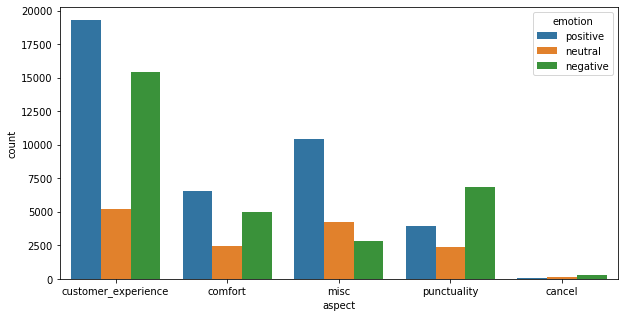

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.countplot(x='aspect', hue='emotion', data=sentiment_aspect_dataset)

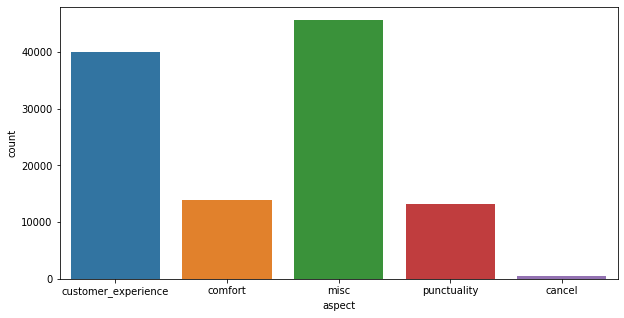

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.countplot(x='aspect', data=sentiment_aspect_dataset)

In [89]:
@interact
def distribution_pie(aspect=sentiment_aspect_dataset['aspect'].unique()):
    import plotly.graph_objects as go

    df = pd.DataFrame(sentiment_aspect_dataset[sentiment_aspect_dataset['aspect']==aspect].groupby('emotion').count())
    labels = df.index
    values = df['score']

    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
    fig.show()

interactive(children=(Dropdown(description='aspect', options=('customer_experience', 'comfort', 'misc', 'punct…

In [105]:
import plotly.express as px


fig = px.box(sentiment_aspect_dataset, x="aspect", y="score",
             notched=True, # used notched shape
             title="Box plot of score distribution",
            )
fig.show()

In [86]:
import itertools
from collections import Counter
import math
from ipywidgets import interact, interactive, fixed, interact_manual

@interact
def word_cloud(aspect=sentiment_aspect_dataset['aspect'].unique(), emotion=sentiment_aspect_dataset['emotion'].unique()):
    import plotly, random
    dataset = sentiment_aspect_dataset[(sentiment_aspect_dataset['aspect']==aspect) & (sentiment_aspect_dataset['emotion']==emotion)]

    stop_words = set(stopwords) 
    tokens = list(itertools.chain.from_iterable(dataset['review_sentence'].str.split()))
    tokens = list(map(lambda s:s.lower().strip(), tokens))
    tokens = [s for s in tokens if s not in stop_words]
    counter = Counter(tokens)

    words = tokens
    colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(50)]
    weights = [math.ceil(c/10) for _, c in counter.items()]

    import plotly.graph_objs as go
    from plotly.offline import iplot
    import random

    data = go.Scatter(x=[random.random() for i in range(50)],
                    y=[random.random() for i in range(50)],
                    mode='text',
                    text=words,
                    marker={'opacity': 0.3},
                    textfont={'size': weights,
                              'color': colors})
    layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                       'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
    fig = go.Figure(data=[data], layout=layout)

    iplot(fig)

interactive(children=(Dropdown(description='aspect', options=('customer_experience', 'comfort', 'misc', 'punct…